In [1]:
using Plots
using BenchmarkTools
gr()

Plots.GRBackend()

In [2]:
"""
    value_iteration(
        return_function,  # Return for transitioning from current to next state
        state_space,      # Vector of possible states
        discount_factor;  # Discount factor β ∈ (0,1)
        tolerance=1e-6,
        max_iterations=1000
    )

Performs value function iteration for a problem where agent directly chooses next state.

Parameters:
- return_function: Function(current_state, next_state) -> reward
- state_space: Vector of possible states
- discount_factor: Discount factor β ∈ (0,1)
- tolerance: Convergence tolerance
- max_iterations: Maximum number of iterations

Returns:
- value_function: Dictionary mapping states to values
- policy: Dictionary mapping states to optimal next states
- iterations: Number of iterations until convergence
- diffs: Array of iteration-wise maximum values of change in value function
"""
function value_iteration(
    return_function,
    state_space,
    discount_factor;
    tolerance=1e-6,
    max_iterations=1000
)
    
    diffs = Float64[] # track differences

    # Initialize value function
    value_function = Dict(s => 0.0 for s in state_space)
    policy = Dict(s => s for s in state_space)  # Initial policy: stay at current state
    
    for iter in 1:max_iterations
        max_diff = 0.0
        value_function_new = Dict()
        
        # Update value for each current state
        for current_state in state_space
            # Find maximum value over all possible next states
            values = Float64[]
            
            # Try each possible next state
            for next_state in state_space
                # Calculate value of choosing this next state:
                # Current reward + discounted future value
                value = return_function(current_state, next_state) + 
                       discount_factor * value_function[next_state]
                push!(values, value)
            end
            
            # Update value function and policy
            max_value, max_index = findmax(values)
            value_function_new[current_state] = max_value
            policy[current_state] = state_space[max_index]
            
            # Track maximum change
            max_diff = max(max_diff, abs(value_function_new[current_state] - 
                                       value_function[current_state]))
        end

        push!(diffs, max_diff)
        
        # Check for convergence
        if max_diff < tolerance
            return value_function_new, policy, iter, diffs
        end
        
        value_function = value_function_new
    end
    
    @warn "Maximum iterations reached without convergence"
    return value_function, policy, max_iterations, diffs
end

value_iteration

In [3]:
function optimal_growth_1(k, k_next)
    # production function: f(k) = Ak^α
    α = 0.33
    A = 1
    δ = 1
    
    # Current production
    production = A*k^α
    
    # Investment needed to reach k_next
    investment = k_next - (1-δ)*k  # δ is depreciation rate
    
    # Consumption is production minus investment
    consumption = production - investment
    
    # Return negative infinity for infeasible transitions
    if consumption <= 0
        return -Inf
    end
    
    # Utility from consumption
    return log(consumption)
end

optimal_growth_1 (generic function with 1 method)

In [4]:
# Function to plot results
function plot_solution(state_space, value_function, policy; 
    true_value_fn=nothing, true_policy_fn=nothing)
# Convert dictionary results to arrays for plotting
value_array = [value_function[s] for s in state_space]
policy_array = [policy[s] for s in state_space]

# Create figure with two subplots
p1 = plot(xlabel="State", title="Value Function", legend=:bottomright)
p2 = plot(xlabel="State", title="Policy Function", legend=:bottomright)

# Plot numerical solutions
plot!(p1, state_space, value_array, label="Numerical", linewidth=2)
plot!(p2, state_space, policy_array, label="Numerical", linewidth=2)

# If true functions are provided, plot them
if true_value_fn !== nothing
true_values = true_value_fn.(state_space)
plot!(p1, state_space, true_values, label="Analytical", 
linestyle=:dash, linewidth=2)
end

if true_policy_fn !== nothing
true_policies = true_policy_fn.(state_space)
plot!(p2, state_space, true_policies, label="Analytical", 
linestyle=:dash, linewidth=2)
end

# Combine plots
plot(p1, p2, layout=(2,1), size=(800,800))
end

plot_solution (generic function with 1 method)

In [5]:
# Set up and solve the problem
k_min_1, k_max_1 = 0.1, 1
state_space_1 = range(k_min_1, k_max_1, length=500)
discount_factor = 0.96

# Solve the problem
value_function_1, policy_1, iterations, diffs_1 = value_iteration(
    optimal_growth_1,
    state_space_1,
    discount_factor
)

(Dict{Any, Any}(0.707815631262525 => -23.016528010625986, 0.9332665330661323 => -22.882970725838227, 0.7402805611222445 => -22.99487117228884, 0.7276553106212424 => -23.00318078143208, 0.5995991983967935 => -23.096674434907893, 0.7114228456913828 => -23.014075590767618, 0.556312625250501 => -23.132873407260345, 0.1432865731462926 => -23.78807435326032, 0.6086172344689379 => -23.0894655101137, 0.9801603206412826 => -22.859294140180772…), Dict(0.707815631262525 => 0.2821643286573146, 0.9332665330661323 => 0.3092184368737475, 0.7402805611222445 => 0.2875751503006012, 0.7276553106212424 => 0.28577154308617236, 0.5995991983967935 => 0.26773547094188377, 0.7114228456913828 => 0.2821643286573146, 0.556312625250501 => 0.2605210420841683, 0.1432865731462926 => 0.16673346693386773, 0.6086172344689379 => 0.2695390781563126, 0.9801603206412826 => 0.31462925851703405…), 339, [1.0003923247024622, 0.940878478547539, 0.8893934605056628, 0.8481308562498993, 0.8122583209278482, 0.7791268198905534, 0.747

In [6]:
"""
Calculate analytical solutions for value and policy functions when:
- Policy function: k' = [βbAk^α]/[1 + βb]
- Value function: v(k) = a + b*ln(k)
where:
- b = α/(1-αβ)
- a = [ln(A(1-αβ)) + (αβ/(1-αβ))ln(Aαβ)]/(1-β)
"""
function get_analytical_solutions(;
    α=0.33,    # Capital share
    β=0.96,   # Discount factor
    A=1.0     # Technology parameter
)
    # Calculate b
    b = α/(1 - α*β)
    
    # Calculate a
    term1 = log(A*(1 - α*β))
    term2 = (α*β/(1 - α*β)) * log(A*α*β)
    a = (term1 + term2)/(1 - β)
    
    # Define policy function
    function true_policy(k)
        return (β*b*A*k^α)/(1 + β*b)
    end
    
    # Define value function
    function true_value(k)
        return a + b*log(k)
    end
    
    return true_policy, true_value, (a=a, b=b)
end

# Get analytical solutions
true_policy_1, true_value_1, params = get_analytical_solutions(
    α=0.33, 
    β=0.96, 
    A=1
)

(var"#true_policy#12"{Float64, Float64, Int64, Float64}(0.33, 0.96, 1, 0.48302107728337235), var"#true_value#13"{Float64, Float64}(-22.849598088940862, 0.48302107728337235), (a = -22.849598088940862, b = 0.48302107728337235))

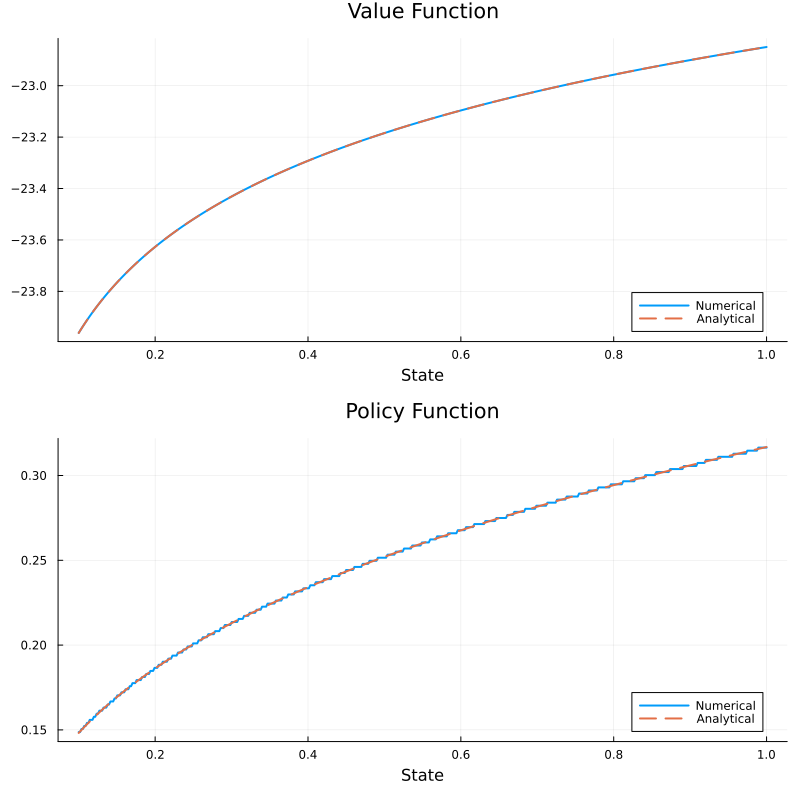

In [7]:
# Plot the results
# You can add your analytical solutions here by replacing `nothing` with actual functions
p = plot_solution(
    state_space_1, 
    value_function_1, 
    policy_1,
    true_value_fn = true_value_1,
    true_policy_fn = true_policy_1
)

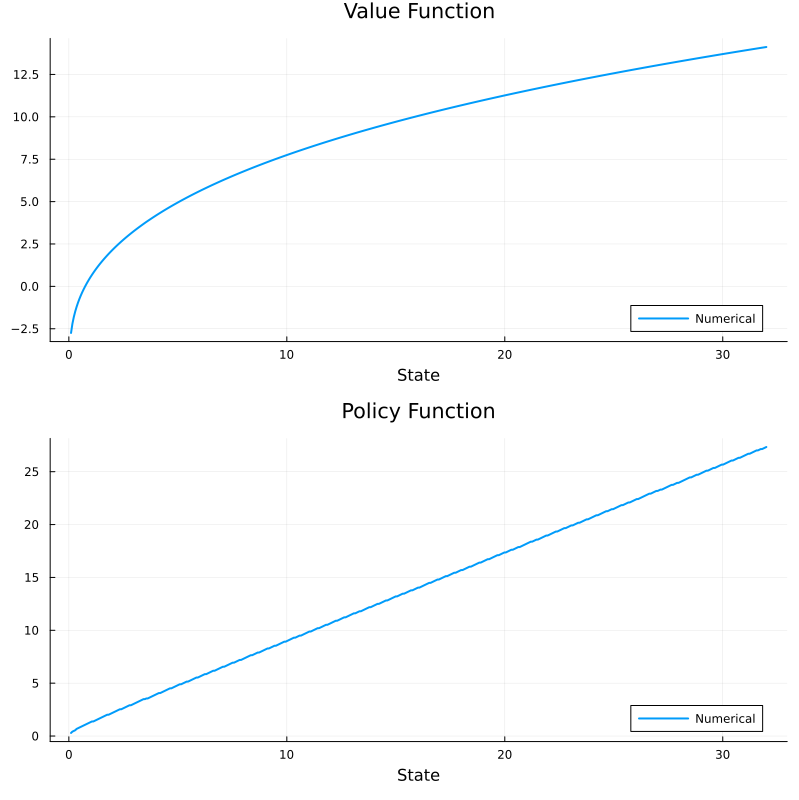

In [8]:
function optimal_growth_2(k, k_next)
    # production function: f(k) = Ak^α
    α = 0.33
    A = 1
    δ = 0.1
    
    # Current production
    production = A*k^α
    
    # Investment needed to reach k_next
    investment = k_next - (1-δ)*k  # δ is depreciation rate
    
    # Consumption is production minus investment
    consumption = production - investment
    
    # Return negative infinity for infeasible transitions
    if consumption <= 0
        return -Inf
    end
    
    # Utility from consumption
    return log(consumption)
end

# Set up and solve the problem
k_min_1, k_max_2 = 0.1, 32
state_space_2 = range(k_min_1, k_max_2, length=500)
discount_factor = 0.96

# Solve the problem
value_function_2, policy_2, iterations, diffs_2 = value_iteration(
    optimal_growth_2,
    state_space_2,
    discount_factor
)

# Plot the results
# You can add your analytical solutions here by replacing `nothing` with actual functions
p = plot_solution(
    state_space_2, 
    value_function_2, 
    policy_2
)

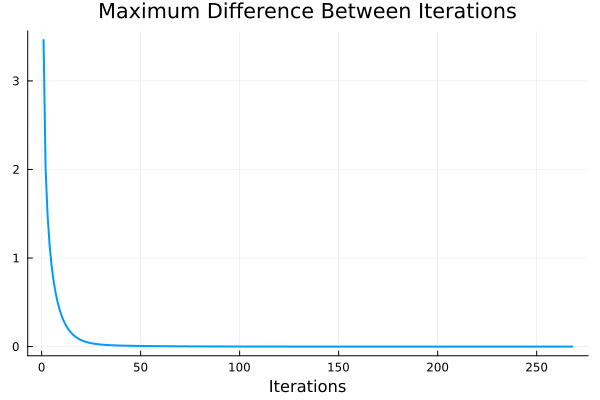

In [9]:
p3 = plot(xlabel="Iterations", title="Maximum Difference Between Iterations")
plot(p3, 1:length(diffs_2), diffs_2, linewidth=2, legend = false)

In [10]:
io = IOBuffer()
@btime value_iteration(optimal_growth_2, state_space_2, discount_factor) |> (x -> println(io, x))

b_0 = String(take!(io))
println(b_0)

  15.054 s (270653018 allocations: 4.99 GiB)
(Dict{Any, Any}(9.625250501002004 => 7.574466434292138, 19.4062124248497 => 11.095168649742218, 18.383366733466932 => 10.794526725212503, 10.520240480961924 => 7.9782408445448345, 4.830661322645291 => 4.826455066066258, 6.62064128256513 => 6.002938592687251, 21.45190380761523 => 11.66515432765705, 24.009018036072145 => 12.32694146240964, 0.2278557114228457 => -1.8048102163072701, 26.246492985971944 => 12.866664334802186, 27.26933867735471 => 13.102863989623764, 12.310220440881764 => 8.720204093724448, 16.721242484969938 => 10.280249765250066, 14.419839679358718 => 9.506960715151285, 27.141482965931864 => 13.073834140114185, 7.451703406813627 => 6.478172146840249, 20.684769539078157 => 11.456041153664948, 20.492985971943888 => 11.403067916086833, 20.812625250501004 => 11.491133835087158, 30.5935871743487 => 13.829144041814398, 2.8488977955911823 => 3.1241627764890727, 7.771342685370741 => 6.65195813981626, 0.8671342685370741 => 0.279542216189

In [11]:
# Function to find steady state
function find_steady_state(policy, state_space)
    current_state = state_space[end÷2]
    for _ in 1:1000
        next_state = policy[current_state]
        if abs(next_state - current_state) < 1e-6
            return current_state, current_state^0.33 - 0.1*current_state
        end
        current_state = next_state
    end
    return nothing
end

find_steady_state (generic function with 1 method)

In [12]:
k_ss_0 = find_steady_state(policy_2, state_space_2)

print(k_ss_0)

(3.5521042084168335, 1.1641481511383762)

In [13]:
function timetester(state_space, discount_factor)
    trial_result = @benchmark value_iteration(optimal_growth_2, $state_space_2, $discount_factor)

    # Return the captured time value
    return trial_result.times[1]
end

timetester (generic function with 1 method)

In [14]:
g_string = [50, 100, 500, 1000, 2000]

# Create a dictionary to store the results 
results = Dict()

# Loop over the values in the array
for g in g_string
    # Set up and solve the problem
    k_min, k_max = 0.1, 32
    state_space = range(k_min_1, k_max, length=g)
    discount_factor = 0.96

    value_function, policy, iter, diffs = value_iteration(optimal_growth_2, state_space, discount_factor, max_iterations=g)

    unpacked1, unpacked2 = find_steady_state(policy, state_space)

    # Run the function and store the result in the dictionary
    results[g] = timetester(state_space, discount_factor), unpacked1, unpacked2
end

┌ Warning: Maximum iterations reached without convergence
└ @ Main In[2]:77
┌ Warning: Maximum iterations reached without convergence
└ @ Main In[2]:77


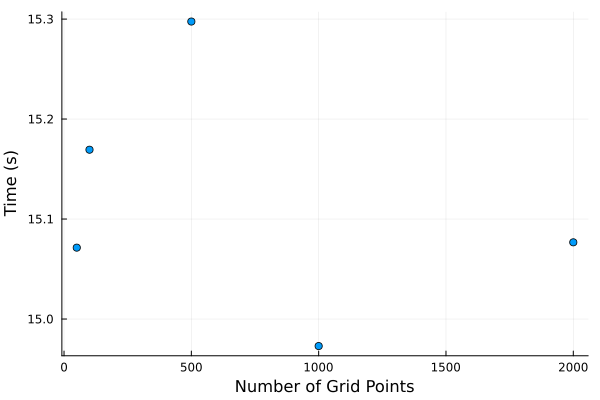

In [15]:
scatter([x for x in keys(results)], [x[1] / 1e9 for x in values(results)], xlabel="Number of Grid Points", ylabel="Time (s)", legend=false)

In [16]:
const k_ss_1 = ((1/discount_factor - 1 + 0.1)/0.33)^(1/(0.33-1))
const c_ss_1 = k_ss_1^0.33 - 0.1*k_ss_1

println(k_ss_1)
println(c_ss_1)

3.5328789171564186
1.1633520474676697


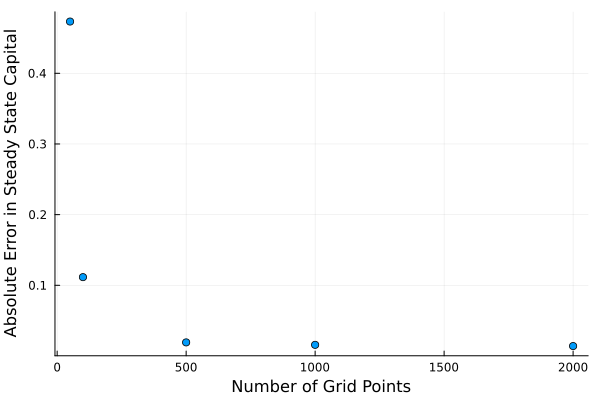

In [17]:
# plot the absolute error in the steady state values by grid size for both capital and consumption
scatter([x for x in keys(results)], [abs(x[2] - k_ss_1) for x in values(results)], xlabel="Number of Grid Points", ylabel="Absolute Error in Steady State Capital", legend=false)

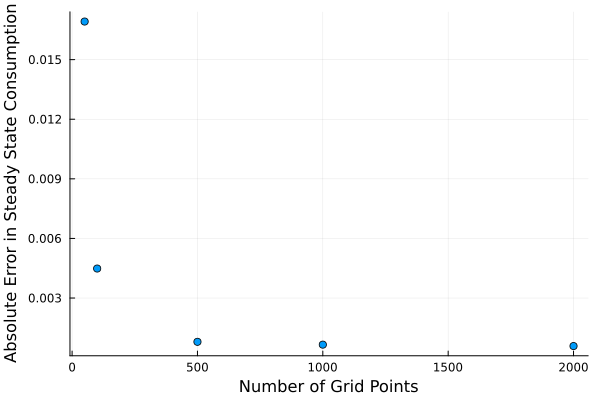

In [18]:
scatter([x for x in keys(results)], [abs(x[3] - c_ss_1) for x in values(results)], xlabel="Number of Grid Points", ylabel="Absolute Error in Steady State Consumption", legend=false)

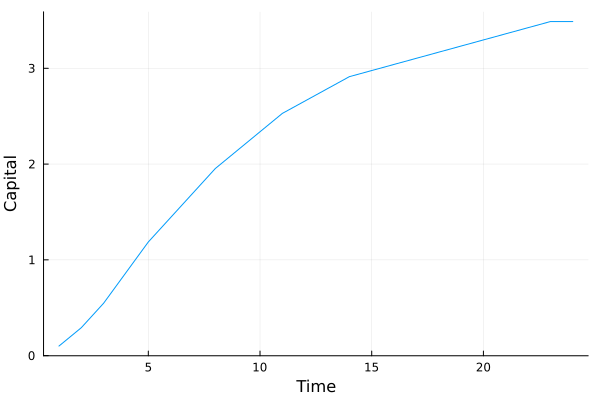

In [19]:
function simulate_path(policy, state_space, k_0)
    current_state = k_0
    path = [current_state]
    for _ in 1:1000
        next_state = policy[current_state]
        if abs(next_state - current_state) < 1e-6
            push!(path, next_state)
            return path
        end
        push!(path, next_state)
        current_state = next_state
    end
    return nothing
end

k_min_3, k_max_3 = 0.1, 32
state_space_3 = range(k_min_3, k_max_3, length=2000)

path = simulate_path(policy_2, state_space_2, 0.1)

plot(path, xlabel="Time", ylabel="Capital", legend=false)

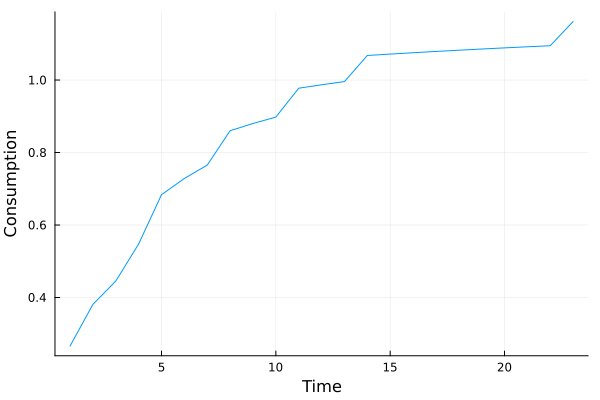

In [20]:
# plot consumption for each time period based on the above path using c = f(k) + (1-δ)k -k' for each period t

function simulate_consumption(path)
    consumption = []
    for i in 1:length(path)-1
        push!(consumption, path[i]^0.33 + 0.9*path[i] - path[i+1])
    end
    return consumption
end

consumption = simulate_consumption(path)

plot(consumption, xlabel="Time", ylabel="Consumption", legend=false)

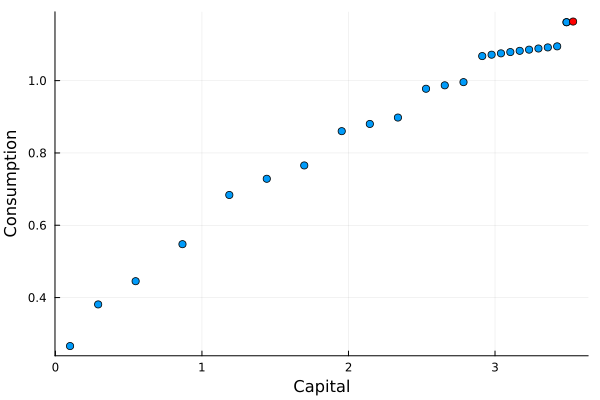

In [21]:
k_ss_2 = k_ss_1
c_ss_2 = c_ss_1

scatter([x for x in path], [x^0.33 + 0.9*x - policy_2[x] for x in path], xlabel="Capital", ylabel="Consumption", legend=false)
scatter!([k_ss_2], [c_ss_2], label="Steady State", color="red")


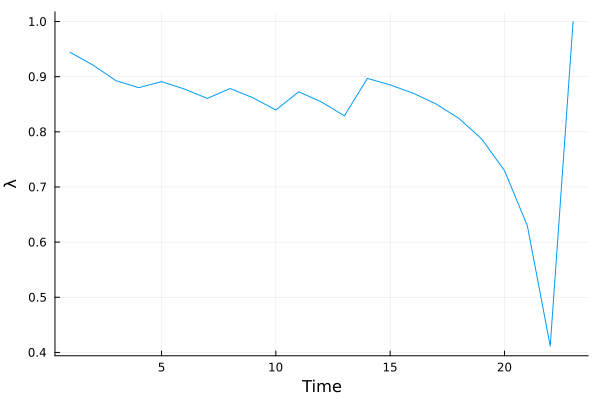

In [22]:
# first compute the sequence lambda_t = kss -k_t / kss - k_{t-1} for each period t, then the half-lives h_t = ln(0.5)/lnlambda_t, and then plot them both over time 

function simulate_halflives(path, k_ss)
    lambda = []
    for i in 2:length(path)
        push!(lambda, (k_ss - path[i])/(k_ss - path[i-1]))
    end
    halflives = []
    for i in 1:length(lambda)
        push!(halflives, log(0.5)/log(lambda[i]))
    end
    return lambda, halflives
end

lambda, halflives = simulate_halflives(path, k_ss_2)

plot(lambda, xlabel="Time", ylabel="λ", legend=false)

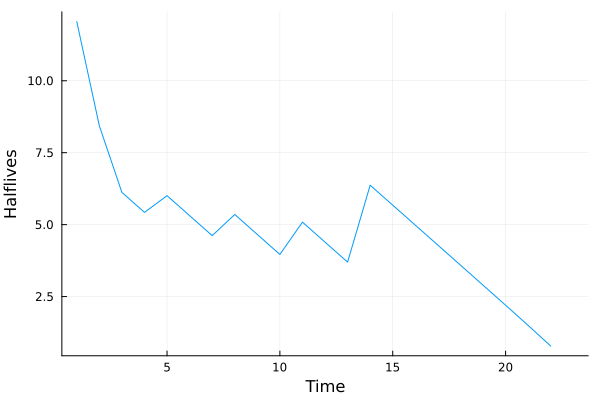

In [23]:
plot(halflives, xlabel="Time", ylabel="Halflives", legend=false)

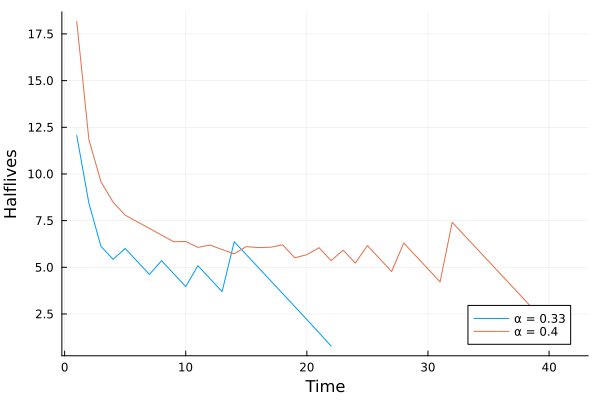

In [24]:
function optimal_growth_3(k, k_next)
    # production function: f(k) = Ak^α
    α = 0.4
    A = 1
    δ = 0.1
    
    # Current production
    production = A*k^α
    
    # Investment needed to reach k_next
    investment = k_next - (1-δ)*k  # δ is depreciation rate
    
    # Consumption is production minus investment
    consumption = production - investment
    
    # Return negative infinity for infeasible transitions
    if consumption <= 0
        return -Inf
    end
    
    # Utility from consumption
    return log(consumption)
end

# Set up and solve the problem

k_min_4, k_max_4 = 0.1, 32
state_space_4 = range(k_min_4, k_max_4, length=2000)
discount_factor = 0.96

# Solve the problem

value_function_3, policy_3, iterations, diffs_3 = value_iteration(
    optimal_growth_3,
    state_space_4,
    discount_factor
)

const k_ss_3 = ((1/discount_factor - 1 + 0.1)/0.4)^(1/(0.4-1))

path_3 = simulate_path(policy_3, state_space_4, 0.1)

lambda_3, halflives_3 = simulate_halflives(path_3, k_ss_3)

plot(halflives, label="α = 0.33", xlabel="Time", ylabel="Halflives", legend=:bottomright)
plot!(halflives_3, label="α = 0.4", xlabel="Time", ylabel="Halflives", legend=:bottomright)